In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
tf.config.run_functions_eagerly(True)

from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
import os

# Ocultar advertencias de TensorFlow y otros warnings innecesarios
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Oculta logs de TensorFlow (0 = todos, 1 = INFO, 2 = WARNING, 3 = ERROR)
warnings.filterwarnings("ignore", category=UserWarning)  # Oculta warnings de Python

# Desactivar ejecución ansiosa (si no la necesitas)
tf.config.run_functions_eagerly(False)


In [139]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [140]:
path = "/home/mike/Escritorio/codes/projects/PropNet/PropNet-project/2_Data_Processing/feature_engineering/processed_data.csv"
data = pd.read_csv(path)
print(data.head())

# Get number of rows and columns
num_rows, num_cols = data.shape

print(f"Number of records (rows): {num_rows}")
print(f"Number of columns: {num_cols}")

# Optional: Display column names
print("\nColumn names:")
print(data.columns.tolist())

   parking  area  prefarea  unfurnished  airconditioning  stories  mainroad  \
0        2  7420         1            0                1        3         1   
1        3  8960         0            0                1        4         1   
2        2  9960         1            0                0        2         1   
3        3  7500         1            0                1        2         1   
4        2  7420         0            0                1        2         1   

      price  basement  semi-furnished  ...  KPI_Mainroad_Area_Ratio  \
0  13300000         0               0  ...                     7420   
1  12250000         0               0  ...                     8960   
2  12250000         1               1  ...                     9960   
3  12215000         1               0  ...                     7500   
4  11410000         1               0  ...                     7420   

   KPI_Stories_per_Land_Area  KPI_Bedrooms_AirConditioning_Ratio  \
0                   0.000404  

In [141]:
X = data.drop(columns=['price'])  # Todas las columnas excepto 'price'
y = data['price']  # Precio de la vivienda

# First check for and handle infinite values
X = X.replace([np.inf, -np.inf], np.nan)

# Then handle NaN values
X = X.fillna(X.mean())

In [142]:
price_scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler(feature_range=(0, 1))

all_scaled_price = price_scaler.fit_transform(y.to_numpy().reshape(-1, 1)) 
all_scaled_vars = scaler.fit_transform(X)

In [143]:
X_train, X_test, y_train, y_test = train_test_split(all_scaled_vars, all_scaled_price, test_size=0.2, random_state=42)

In [144]:
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# y_train_scaled = scaler.fit_transform(y_train)
# y_test_scaled = scaler.transform(y_test)


X_train_scaled = X_train
X_test_scaled = X_test

y_train_scaled = y_train
y_test_scaled = y_test


print(X_train_scaled.shape)
print(y_train_scaled.shape)
print(X_test_scaled.shape)
print(y_test_scaled.shape)

(2436, 41)
(2436, 1)
(609, 41)
(609, 1)


In [145]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam, Lion
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Dropout

def build_model(optimizer_name='SGD'):
    optimizers_dict = {
        'Adam': Adam(learning_rate=0.001),
        'SGD': SGD(learning_rate=0.001, momentum=0.9),
        'RMSprop': RMSprop(learning_rate=0.001),
        'Adagrad': Adagrad(learning_rate=0.001),
        'Adadelta': Adadelta(learning_rate=1.0),
        'Adamax': Adamax(learning_rate=0.002),
        'Nadam': Nadam(learning_rate=0.001),
        'Lion' : Lion(learning_rate=0.001)
    }

    if optimizer_name not in optimizers_dict:
        raise ValueError(f"Optimizador {optimizer_name} no reconocido. Opciones válidas: {list(optimizers_dict.keys())}")

    optimizer = optimizers_dict[optimizer_name]

    model = Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        # layers.Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        # layers.Dropout(0.4),  # Dropout aumentado
        layers.Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        layers.Dropout(0.2),  # Dropout aumentado
        layers.Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        layers.Dropout(0.2),  # Dropout en cada capa para reducir sobreajuste
        layers.Dense(24, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        layers.Dropout(0.2),  # Dropout en cada capa
        layers.Dense(1)  # Capa de salida
    ])
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model


In [146]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

# Definir validación cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Lista de optimizadores a probar
optimizers = ['Adam', 'SGD', 'Adadelta', 'Lion']

# Diccionario para almacenar resultados
results = {}

early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

for opt_name in optimizers:
    fold_mae = []

    print(f"Entrenando con el optimizador: {opt_name}")

    for train_idx, val_idx in kfold.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train_scaled[train_idx], y_train_scaled[val_idx]

        try:
            # Crear un nuevo modelo con el optimizador especificado
            model = build_model(optimizer_name=opt_name)

            # Entrenar el modelo
            history = model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=24,
                                        validation_data=(X_val_fold, y_val_fold), verbose=0,
                                        callbacks=[early_stopping])

            # Evaluar el modelo
            val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]
            fold_mae.append(val_mae)

        except ValueError as e:
            print(f"Error con optimizador {opt_name}: {e}")
            continue  # Saltar a la siguiente iteración si hay un error

    # Guardar el MAE promedio en los resultados solo si hubo evaluaciones válidas
    if fold_mae:
        results[opt_name] = np.mean(fold_mae)
    else:
        results[opt_name] = float('inf')  # Asignar un valor alto si no se pudo entrenar

print('============================================================')
# Imprimir los resultados de validación cruzada
print("\nResultados de Validación Cruzada (MAE promedio):")
for opt, mae in results.items():
    print(f"{opt}: {mae:.4f}")
print('============================================================')
# Seleccionar el mejor optimizador
best_optimizer_name = min(results, key=results.get)
print(f"\nMejor optimizador seleccionado: {best_optimizer_name}")
print('============================================================')

Entrenando con el optimizador: Adam
Entrenando con el optimizador: SGD
Entrenando con el optimizador: Adadelta
Entrenando con el optimizador: Lion

Resultados de Validación Cruzada (MAE promedio):
Adam: 0.1014
SGD: 0.0979
Adadelta: 0.1023
Lion: 0.1007

Mejor optimizador seleccionado: SGD


In [147]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Elegir el mejor optimizador basado en el menor MAE promedio
best_optimizer_name = min(results, key=results.get)
# best_optimizer_name = 'Lion'
print(f"Mejor optimizador seleccionado: {best_optimizer_name}")

# Construir y entrenar el modelo final con el mejor optimizador
model = build_model(optimizer_name=best_optimizer_name)

Mejor optimizador seleccionado: SGD


In [148]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=250, batch_size=32,
                    validation_split=0.2, verbose=1, callbacks=[
                        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
                        # Puedes agregar más callbacks como TensorBoard si es necesario
                    ])

Epoch 1/250


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 8.0302 - mae: 0.2337 - val_loss: 7.6051 - val_mae: 0.1136 - learning_rate: 0.0010
Epoch 2/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4836 - mae: 0.1272 - val_loss: 7.0994 - val_mae: 0.1079 - learning_rate: 0.0010
Epoch 3/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9803 - mae: 0.1141 - val_loss: 6.6154 - val_mae: 0.1043 - learning_rate: 0.0010
Epoch 4/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5007 - mae: 0.1103 - val_loss: 6.1523 - val_mae: 0.1031 - learning_rate: 0.0010
Epoch 5/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0413 - mae: 0.1076 - val_loss: 5.7095 - val_mae: 0.1022 - learning_rate: 0.0010
Epoch 6/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6028 - mae: 0.1013 - val_loss: 5.2873 - val_mae: 0.1017 - learning_rate: 0.0010
Epoch 7/250
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1873 - mae: 0.1047 - val_loss: 4.8843 - val_mae: 0.1014 - learning_rate: 0.0010
Epoch 8/250
61/61 ━━━━━━

In [149]:
print(y_test)

[[0.28759957]
 [0.29684996]
 [0.08103671]
 [0.21346355]
 [0.07488883]
 [0.03030303]
 [0.12121203]
 [0.38580736]
 [0.23636364]
 [0.1928742 ]
 [0.85256139]
 [0.10277905]
 [0.25544017]
 [0.45757576]
 [0.12121212]
 [0.22629394]
 [0.27518364]
 [0.11818182]
 [0.22286139]
 [0.3968781 ]
 [0.21455645]
 [0.0969697 ]
 [0.40375974]
 [0.16670468]
 [0.14359714]
 [0.24327169]
 [0.17065472]
 [0.17154173]
 [0.27272727]
 [0.27081264]
 [0.03735455]
 [0.22537247]
 [0.22637714]
 [0.40341429]
 [0.26059091]
 [0.35898095]
 [0.24718563]
 [0.43204234]
 [0.24242424]
 [0.10821325]
 [0.27272727]
 [0.18787879]
 [0.26086848]
 [0.10493281]
 [0.28181818]
 [0.49090909]
 [0.14920294]
 [0.28787879]
 [0.5030303 ]
 [0.34135186]
 [0.12849212]
 [0.29964009]
 [0.29244745]
 [0.28484848]
 [0.29090909]
 [0.29596623]
 [0.08712017]
 [0.34545455]
 [0.67886381]
 [0.3030303 ]
 [0.78774701]
 [0.20167965]
 [0.22776797]
 [0.1030303 ]
 [0.38484848]
 [0.3701    ]
 [0.32575004]
 [0.21212121]
 [0.18411506]
 [0.47918442]
 [0.2274439 ]
 [0.18

In [150]:
y_pred = model.predict(X_test_scaled)

y_pred_unscaled = price_scaler.inverse_transform(y_pred)
y_test_unscaled = price_scaler.inverse_transform(y_test_scaled)

# Calcular métricas sobre los valores desnormalizados
mae_train_real = mean_absolute_error(y_pred_unscaled, y_test_unscaled)

rmse_train_real = np.sqrt(mean_squared_error(y_pred_unscaled, y_test_unscaled))

r2_train_real = r2_score(y_test_unscaled, y_pred_unscaled)

# Calcular el RMSE como porcentaje de la media de los datos de prueba desnormalizados
mean_value_real = np.mean(y_test_unscaled)
rmse_percentage_real = (rmse_train_real / mean_value_real) * 100

# Imprimir las métricas desnormalizadas
print("\nMétricas de Entrenamiento (desnormalizadas):")
print(f'MAE: {mae_train_real:.4f}')
print(f'RMSE: {rmse_train_real:.4f}')
print(f'R²: {r2_train_real:.4f}')

if rmse_percentage_real > 15:
    print(f'El RMSE es superior al 15% de la media: {rmse_percentage_real:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Métricas de Entrenamiento (desnormalizadas):
MAE: 1252974.6806
RMSE: 1662809.6442
R²: -0.0004
El RMSE es superior al 15% de la media: 35.24%


ValueError: x and y must be the same size

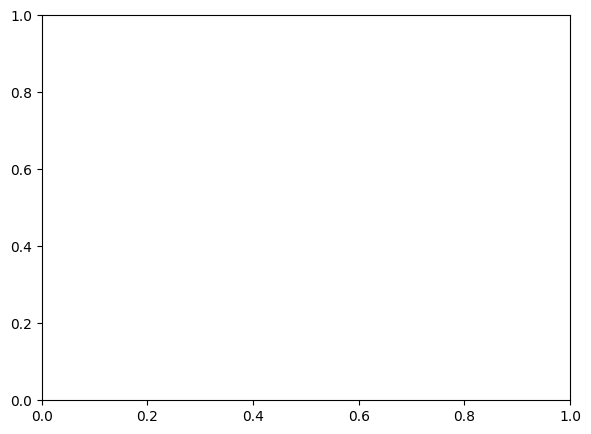

In [151]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.scatter(y_train, y_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title(f'Entrenamiento\nMAE: {mae_train_real:.4f}, RMSE: {rmse_train_real:.4f}')

plt.subplot(122)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title(f'Prueba\nMAE: {mae_train_real:.4f}, RMSE: {rmse_train_real:.4f}')

plt.tight_layout()
plt.show()